# SFH reconstruction test suite

Now that we have started up the package and built an atlas, let's see how we do at fitting SFHs for various galaxy demographics - starforming, starbursting, quenched and rejuvenated galaxies. First thing, let's load the package:

In [1]:
import numpy as np
import dense_basis as db

Starting dense_basis. please wait ~ a minute for the FSPS backend to initialize.
Initialized stellar population with FSPS.


Next we load the atlas that we built previously, with

In [2]:
fname = 'test_atlas'
N_pregrid = 300000
Nparam = 3
path = 'internal'

pg_sfhs, pg_Z, pg_Av, pg_z, pg_seds, norm_method = db.load_atlas(fname, N_pregrid, Nparam, path=path) 
pg_theta = [pg_sfhs, pg_Z, pg_Av, pg_z, pg_seds]

## Different SFH shapes:

We now define SFH-tuples corresponding to galaxies from different demographics, as follows:

In [3]:
rising_sfh = np.array([10.0,1.5,3,0.5,0.7,0.85])
regular_sfg_sfh = np.array([10.0,0.35,3,0.3,0.55,0.8])
post_starburst_sfh = np.array([10.0,0.6,3,0.5,0.8,0.9])
old_quenched_sfh = np.array([10.0,-10.0,3,0.15,0.3,0.5])
double_peaked_SF_sfh = np.array([10.0,0.5,3,0.25,0.30,0.7])
double_peaked_Q_sfh = np.array([10.0,-1.0,3,0.1,0.6,0.7])

sfh_list = [rising_sfh, regular_sfg_sfh, post_starburst_sfh, old_quenched_sfh, double_peaked_SF_sfh, double_peaked_Q_sfh]
sfh_names = ['Rising/Starburst galaxy', 'Regular star-forming galaxy', 'Post-Starburst galaxy', 'Quiescent SFH', 'Double-peaked SFH [SF]', 'Double-peaked SFH [quiescent]']

## Plotting posteriors after fitting these SFHs:

We then loop through these SFHs, and
- generate corresponding SEDs with randomly sampled values for dust, metallicity, and redshifts (although $z\sim 1$)
- fit these SEDs using the dense basis SED fitter, and
- use the resulting likelihood surface to plot and SFH posterior, comparing it to the truth

Since FSPS takes a while to load up the grids corresponding to different metallicities, the following cell might take a while when executed the first time, but subsequent runs should be fast.

In [4]:
priors = db.Priors()
priors.Nparam = Nparam
priors.tx_alpha = 3.0

In [5]:
def sfh_fitting_test(sfh_tuple, sfh_name, max_num = 1000):
    
    print('---------- '+sfh_name+' ------------')
    
    rand_sfh_tuple, rand_Z, rand_Av, rand_z = priors.sample_all_params_safesSFR(random_seed = 7)
    rand_sfh_tuple = sfh_tuple
    
    # generate an SFH corresponding to the SFH-tuple and see how it looks: 
    rand_sfh, rand_time = db.tuple_to_sfh(rand_sfh_tuple, zval = rand_z) 
    # fig = db.plot_sfh(rand_time, rand_sfh, lookback=True) 
    sfh_truths = [rand_time, rand_sfh]

    # generate a corresponding spectrum and multiply by filter curves to get the SED: 
    _, sfr_true, mstar_true = db.make_spec(rand_sfh_tuple, rand_Z, rand_Av, rand_z, return_ms = True)
    rand_spec, rand_lam = db.make_spec(rand_sfh_tuple, rand_Z, rand_Av, rand_z, return_lam = True)
    
    filter_list = 'filter_list_goodss.dat'
    filt_dir = 'internal'
    obs_sed = db.calc_fnu_sed(rand_spec, rand_z, rand_lam, fkit_name = filter_list, filt_dir = filt_dir) 
    obs_err = obs_sed * 0.1 # S/N of 33
    sed_truths = (mstar_true, sfr_true, rand_sfh_tuple[3:], rand_Z, rand_Av, rand_z)
    sed_truths = np.hstack(sed_truths)
    
    chi2_array = db.fit_sed_pregrid(obs_sed, obs_err,
    pg_theta, return_val = 'chi2', norm_method=norm_method)
    
    db.plot_SFH_posterior_v3(chi2_array, obs_sed, pg_theta, truths=sfh_truths, sfh_threshold=0.1, max_num = max_num)

---------- Rising/Starburst galaxy ------------
truncated to 1000 SFHs to reduce computation time. increase max_num if desired.


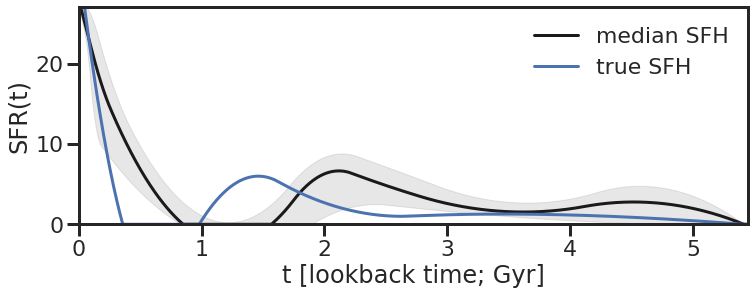

---------- Regular star-forming galaxy ------------
truncated to 1000 SFHs to reduce computation time. increase max_num if desired.


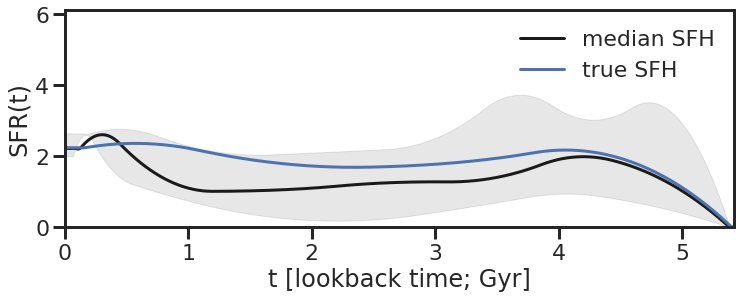

---------- Post-Starburst galaxy ------------
truncated to 1000 SFHs to reduce computation time. increase max_num if desired.


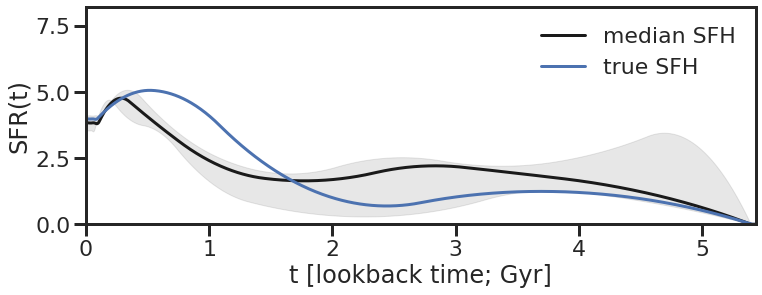

---------- Quiescent SFH ------------
truncated to 1000 SFHs to reduce computation time. increase max_num if desired.


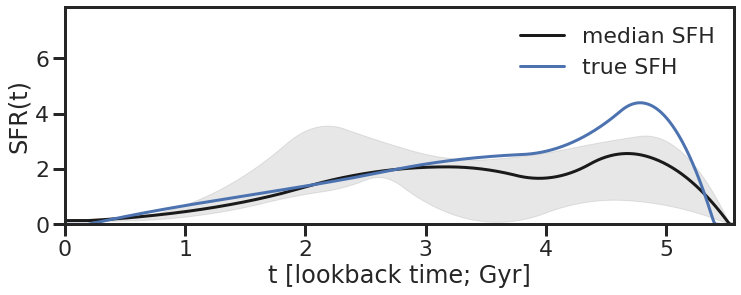

---------- Double-peaked SFH [SF] ------------
truncated to 1000 SFHs to reduce computation time. increase max_num if desired.


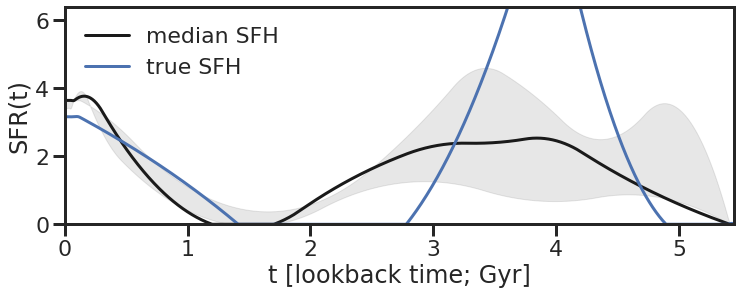

---------- Double-peaked SFH [quiescent] ------------
truncated to 1000 SFHs to reduce computation time. increase max_num if desired.


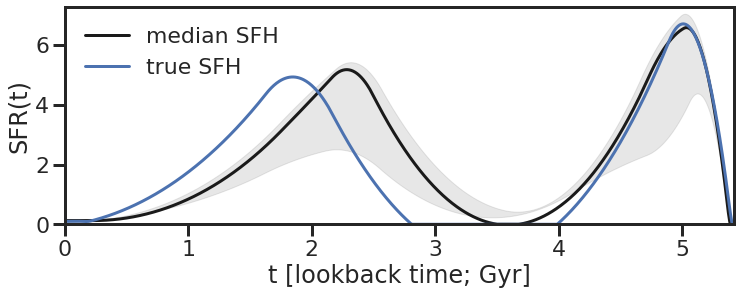

In [6]:
for i in range(len(sfh_list)):

    sfh_fitting_test(sfh_list[i], sfh_names[i])

We see that we do well in recovering the general shape of the SFHs, as well as derived quantities like stellar mass and recent SFR. The poorer reconstructions are discussed below in a bit more detail:
- **Post-starburst galaxy**: While most of the true SFH is within the uncertainties, the reconstruction is not able to completely recover the recent SF prior to the quenching. This is mostly a prior issue, with post-starburst galaxies disfavoured by our adopted prior - in this case, going to larger Nparam or coupling the sSFR to the redshift allows for more variety in the SFH shapes and helps recover this population.
- **Double-peaked quenched galaxy**: while this performs reasonably well, the peaks are poorly constrained due to low S/N from the old stellar populations. In this case, we actually find th older peak to be better constrained mainly because the SFH has to be 0 at the big bang. This also leads to the uncertainties not being estimated accurately, which is also usually mitigated by a larger atlas.
- **Old quiescent galaxy and the double-peaked SF galaxy**: This is simply a S/N issue. The fitter detects that the galaxy is quiescent, but doesn't have enough information to accurately constrain the older stellar populations, leading to the posterior being prior rather than likelihood dominated.